# SPIRE-NEP master catalogue
## Preparation of SEIP data

This catalogue comes from `dmu0_SEIP`.

In the catalogue, we keep:





In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
1407877 (Mon Feb 4 12:56:29 2019 +0000)


In [8]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, flux_to_mag

In [9]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "seip_ra"
DEC_COL = "seip_dec"

## I - Column selection

In [10]:
imported_columns = OrderedDict({
        "objid":     "seip_id",
        "ra":        "seip_ra",
        "dec":       "seip_dec",
        "i1_f_ap2":  "f_ap_irac_i1",
        "i1_df_ap2": "ferr_ap_irac_i1",
        "i2_f_ap2":  "f_ap_irac_i2",
        "i2_df_ap2": "ferr_ap_irac_i2",
        "i3_f_ap2":  "f_ap_irac_i3",
        "i3_df_ap2": "ferr_ap_irac_i3",
        "i4_f_ap2":  "f_ap_irac_i4",
        "i4_df_ap2": "ferr_ap_irac_i4",

    })


catalogue = Table.read("../../dmu0/dmu0_SEIP/data/SEIP_SPIRE-NEP.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2012

# Clean table metadata
catalogue.meta = None

In [12]:
# Adding flux and band-flag columns
for col in catalogue.colnames:
    if col.startswith('f_'):
        
        errcol = "ferr{}".format(col[1:])
        
        # -999 is used for missing values
        catalogue[col][catalogue[col] < -900] = np.nan
        catalogue[errcol][catalogue[errcol] < -900] = np.nan     
        
        mag, error = flux_to_mag(np.array(catalogue[col]*1.e-6), np.array(catalogue[errcol]*1.e-6))
        
        # Fluxes are added in µJy
        catalogue.add_column(Column(mag , name="m{}".format(col[1:])))
        catalogue.add_column(Column(error , name="m{}".format(errcol[1:])))
        
        # Band-flag column
        #catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))
        
# TODO: Set to True the flag columns for fluxes that should not be used for SED fitting.

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)
/Users/rs548/anaconda/env

In [14]:
#Only keep irac i1 detected objects
catalogue = catalogue[~np.isnan(catalogue['f_ap_irac_i1'])]

In [15]:
catalogue[:10].show_in_notebook()

idx,seip_id,seip_ra,seip_dec,f_ap_irac_i1,ferr_ap_irac_i1,f_ap_irac_i2,ferr_ap_irac_i2,f_ap_irac_i3,ferr_ap_irac_i3,f_ap_irac_i4,ferr_ap_irac_i4,m_ap_irac_i1,merr_ap_irac_i1,m_ap_irac_i2,merr_ap_irac_i2,m_ap_irac_i3,merr_ap_irac_i3,m_ap_irac_i4,merr_ap_irac_i4
,,deg,deg,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,,,,,,,,
0,SSTSL2 J174232.97+685830.3,265.637381,68.975086,23.89,0.3795,32.03,0.8764,34.4,2.49,nan,nan,20.454459625625297,0.017247253650301803,20.13610765334044,0.029707749292851218,20.05860389357118,0.0785896264490623,nan,nan
1,SSTSL2 J174232.88+685852.7,265.637004,68.981326,24.04,0.3363,28.95,0.8183,nan,nan,20.74,3.561,20.44766384167324,0.015188564295347708,20.245878579841353,0.030689393311004395,nan,nan,20.607978119867447,0.1864178700647878
2,SSTSL2 J174233.91+685909.1,265.641315,68.985886,31.27,0.3646,31.24,0.8701,nan,nan,nan,nan,20.162180296892664,0.012659399432517236,20.163222436986835,0.030240047111397196,nan,nan,nan,nan
3,SSTSL2 J174233.96+685916.6,265.641541,68.987957,27.51,0.3556,22.73,0.7822,nan,nan,nan,nan,20.301273524025795,0.014034452723082182,20.50850141068758,0.03736308224205054,nan,nan,nan,nan
4,SSTSL2 J174234.11+685922.4,265.642151,68.989574,33.39,0.4285,28.39,0.7529,nan,nan,26.97,4.194,20.09095895236407,0.013933452043691478,20.267086518685353,0.028793617068066067,nan,nan,20.322797633867772,0.1688386222749572
5,SSTSL2 J174231.02+685923.3,265.629284,68.989824,13.78,0.3186,9.116,0.6484,nan,nan,nan,nan,21.051876956070977,0.025102725314654573,21.500489208729157,0.07722590556879892,nan,nan,nan,nan
6,SSTSL2 J174232.44+685937.9,265.635199,68.993877,10.77,0.3755,16.72,0.6894,nan,nan,5.536,3.321,21.319460741755044,0.03785459098297842,20.841909317242504,0.04476713753350804,nan,nan,22.042009796378245,0.6513240491332638
7,SSTSL2 J174232.05+685932.9,265.633561,68.992499,21.41,0.4072,20.44,0.7111,nan,nan,25.58,3.401,20.573458331763895,0.020649779662658116,20.623797771343312,0.03777235886514216,nan,nan,20.380248649643413,0.14435452824012504
8,SSTSL2 J174203.53+685213.0,265.514735,68.870298,18.08,0.3869,nan,nan,nan,nan,nan,nan,20.757003934651642,0.023234034160449134,nan,nan,nan,nan,nan,nan


## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [16]:
SORT_COLS = ['merr_ap_irac_i1', 'merr_ap_irac_i2', 'merr_ap_irac_i3', 'merr_ap_irac_i4']
FLAG_NAME = 'ps1_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(catalogue, RA_COL, DEC_COL,  sort_col=SORT_COLS, flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

The initial catalogue had 10111 sources.
The cleaned catalogue has 8972 sources (1139 removed).
The cleaned catalogue has 1139 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [17]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_SPIRE-NEP.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

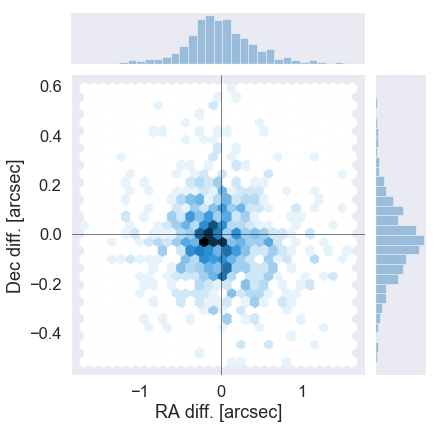

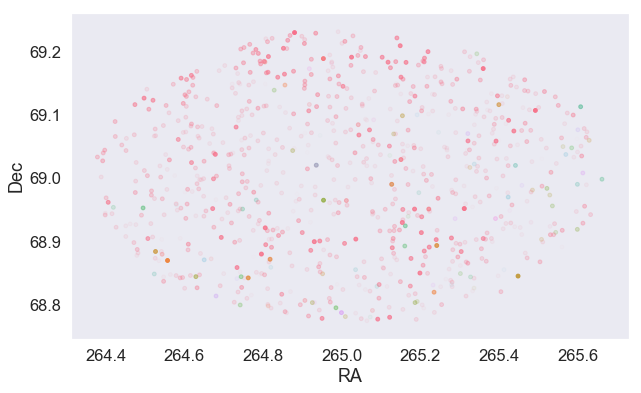

In [18]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

In [19]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: 0.038788020015090297 arcsec
Dec correction: 0.0320336816400868 arcsec


In [20]:
catalogue[RA_COL] +=  delta_ra.to(u.deg)
catalogue[DEC_COL] += delta_dec.to(u.deg)

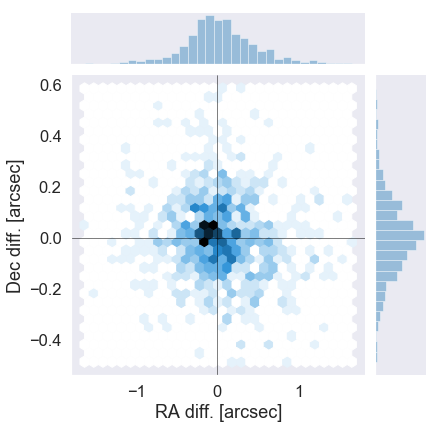

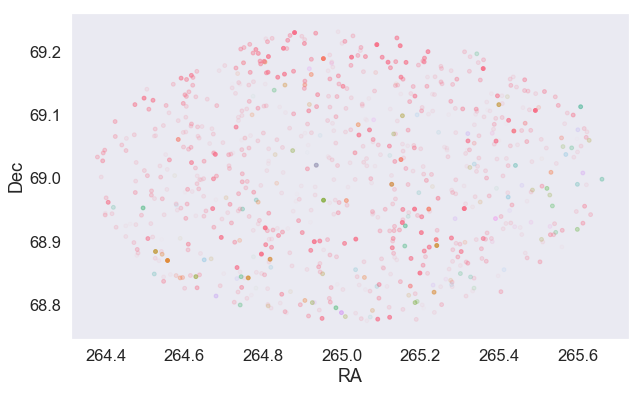

In [21]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

## IV - Flagging Gaia objects

In [23]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [24]:
GAIA_FLAG_NAME = "seip_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

828 sources flagged.


## V - Flagging objects near bright stars

# VI - Saving to disk

In [25]:
catalogue.write("{}/SEIP.fits".format(OUT_DIR), overwrite=True)